In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import statsmodels.api as sm
import scipy.stats as stats

import yfinance as yf

In [7]:
# Define the ticker symbol for Apple
ticker = 'AAPL'

# Get the data of the stock
data = yf.download(ticker, start="2020-01-01", )
print(data.shape)

[*********************100%***********************]  1 of 1 completed

(1223, 6)


In [8]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-02 00:00:00+00:00,72.796021,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03 00:00:00+00:00,72.088310,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06 00:00:00+00:00,72.662704,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07 00:00:00+00:00,72.320969,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08 00:00:00+00:00,73.484360,75.797501,76.110001,74.290001,74.290001,132079200


### PCA weights from a risk distribution R

In [9]:
def pcaWeights(cov, riskDist=None, riskTarget=1.):
    eVal, eVec = np.linalg.eig(cov)
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices], eVec[:, indices]
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1
    loads = riskTarget * (riskDist/eVal)**.5
    wghts = np.dot(eVec, loads.reshape(-1, 1))
    return wghts

In [10]:
matrixSize = 3 
np.random.seed(0)
A = np.random.rand(matrixSize, matrixSize)
B = np.dot(A, A.transpose())
pcaWeights(B)

array([[ 4.91041938],
       [-3.132718  ],
       [-1.73855105]])

#### The symmetric CUSUM Filter

In [11]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos + diff.loc[i].values[0]), min(0, sNeg + diff.loc[i].values[0])
        if sPos > h:
            sPos = 0
            tEvents.append(i)
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
    return tEvents

In [12]:
prices = data['Close']
events = getTEvents(prices, 5)

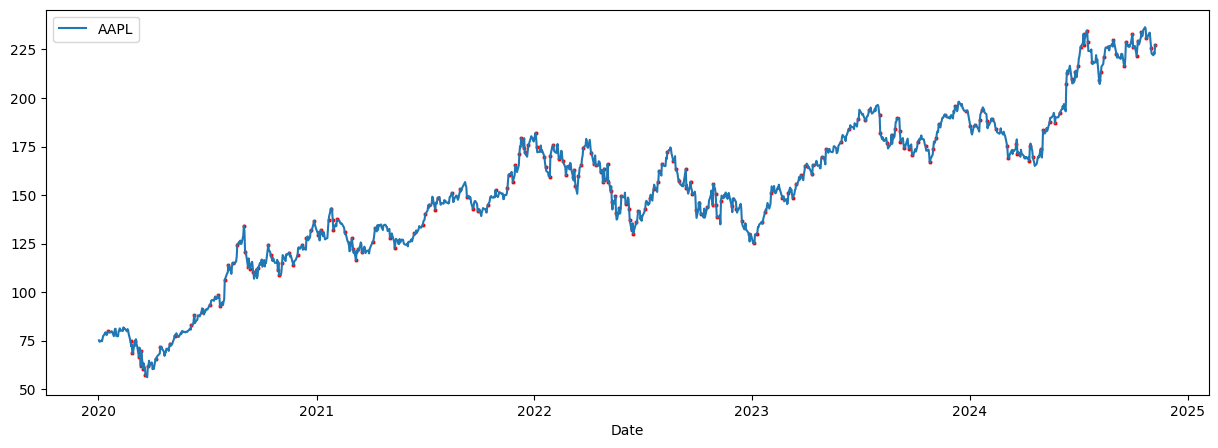

In [13]:
plt.figure(figsize=(15,5))
sns.lineplot(data['Close'])
sns.scatterplot(x=pd.Series(events),y=data.loc[events,'Close'].values.reshape(-1), s=10, color="red")
plt.show()

## Exercise

In [14]:
## get the data
es_data = yf.download("ES=F", start='2023-01-01', end='2024-11-10', interval="1h") 
print(es_data.shape)

[*********************100%***********************]  1 of 1 completed

(10663, 6)


In [15]:
es_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ES=F,ES=F,ES=F,ES=F,ES=F,ES=F
Datetime,,,,,,
2023-01-03 05:00:00+00:00,3871.50,3871.50,3873.75,3864.00,3864.00,8894
2023-01-03 06:00:00+00:00,3870.50,3870.50,3874.25,3866.25,3871.50,7627
2023-01-03 07:00:00+00:00,3881.75,3881.75,3882.00,3865.75,3870.25,16333
2023-01-03 08:00:00+00:00,3895.25,3895.25,3897.00,3877.50,3881.50,38641
2023-01-03 09:00:00+00:00,3906.00,3906.00,3906.25,3894.50,3895.25,36179


In [16]:
es_data.columns = es_data.columns.get_level_values(0)

In [17]:
es_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Datetime,,,,,,
2023-01-03 05:00:00+00:00,3871.50,3871.50,3873.75,3864.00,3864.00,8894
2023-01-03 06:00:00+00:00,3870.50,3870.50,3874.25,3866.25,3871.50,7627
2023-01-03 07:00:00+00:00,3881.75,3881.75,3882.00,3865.75,3870.25,16333
2023-01-03 08:00:00+00:00,3895.25,3895.25,3897.00,3877.50,3881.50,38641
2023-01-03 09:00:00+00:00,3906.00,3906.00,3906.25,3894.50,3895.25,36179


In [18]:
def advanced_bars(series, h, bar_type = 'Volume'):
    index_name = es_data.index.name
    df = pd.DataFrame()
    temp_data = series.reset_index()
    current_vol = 0
    for i in range(len(temp_data)):
        if current_vol == 0:
                date, cum_high,cum_low,cum_open,cum_close,cum_adj_close = temp_data.iloc[i][index_name],temp_data.iloc[i]['High'],temp_data.iloc[i]['Low'],temp_data.iloc[i]['Open'],temp_data.iloc[i]['Close'],temp_data.iloc[i]['Adj Close']
        cum_high, cum_low = max(cum_high, temp_data.iloc[i]['High']), min(cum_low, temp_data.iloc[i]['Low'])
        if bar_type == 'Volume':
            current_vol += temp_data.iloc[i]['Volume']
        elif bar_type == 'Dollar':
            current_vol += temp_data.iloc[i]['Volume'] * temp_data.iloc[i]['Close']
        elif bar_type == 'Tick':
            current_vol += 1
        else:
            raise ValueError("bar_type Wrong! Please enter correct bar_type: Volume, Dollar or Tick")

        if (current_vol >= h):
            cum_close = temp_data.iloc[i][ 'Close']
            cum_adj_close = temp_data.iloc[i]['Adj Close']
            temp = pd.DataFrame([[date, cum_adj_close, cum_close, cum_high, cum_low, cum_open, current_vol]], columns = [index_name,'Adj Close','Close','High','Low','Open','Cum '+bar_type])
            current_vol = 0
            df = pd.concat([df, temp], axis=0)
    df.set_index(index_name, inplace=True)
    return df

In [19]:
tick_bars = advanced_bars(es_data, h=2, bar_type='Tick')
tick_bars.shape

(5331, 6)

In [20]:
volume_bars = advanced_bars(es_data, h=20000, bar_type='Volume')
volume_bars.shape

(6358, 6)

In [21]:
dollar_bars = advanced_bars(es_data, h=20000*5000, bar_type='Dollar')
dollar_bars.shape

(6274, 6)

In [22]:
tick_bars

,Adj Close,Close,High,Low,Open,Cum Tick
Datetime,,,,,,
2023-01-03 05:00:00+00:00,3870.50,3870.50,3874.25,3864.00,3864.00,2
2023-01-03 07:00:00+00:00,3895.25,3895.25,3897.00,3865.75,3870.25,2
2023-01-03 09:00:00+00:00,3897.25,3897.25,3906.75,3893.50,3895.25,2
2023-01-03 11:00:00+00:00,3880.00,3880.00,3898.50,3870.25,3897.25,2
2023-01-03 13:00:00+00:00,3854.00,3854.00,3901.50,3853.25,3879.75,2
...,...,...,...,...,...,...
2024-11-08 11:00:00+00:00,6002.25,6002.25,6002.75,5990.25,5994.25,2
2024-11-08 13:00:00+00:00,6015.00,6015.00,6015.50,5997.50,6002.00,2
2024-11-08 15:00:00+00:00,6022.75,6022.75,6025.50,6008.50,6014.50,2


In [23]:
tick_counts = tick_bars.resample('W-MON')['Close'].count()
dollar_counts = dollar_bars.resample('W-MON')['Close'].count()
volume_counts = volume_bars.resample('W-MON')['Close'].count()

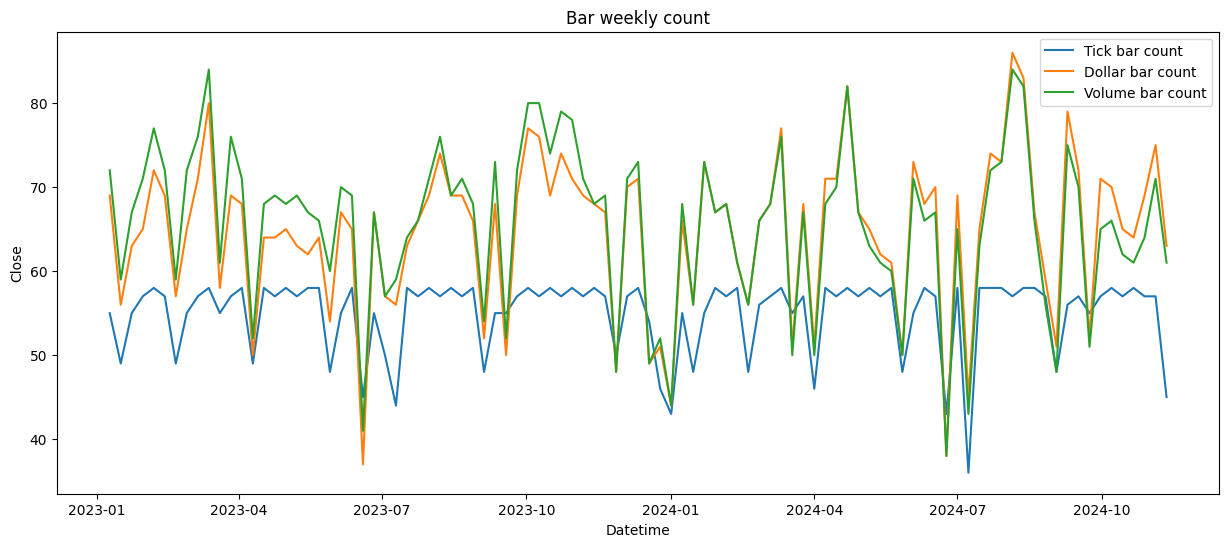

In [24]:
plt.figure(figsize=(15, 6))
sns.lineplot(tick_counts, label='Tick bar count')
sns.lineplot(dollar_counts, label = 'Dollar bar count')
sns.lineplot(volume_counts, label = 'Volume bar count')
plt.title("Bar weekly count")
plt.show()

In [25]:
count_df = pd.DataFrame(columns = ['count_mean', 'count_std'], index=['tick', 'volume', 'dollar'])
count_df.loc['tick'] = [tick_counts.mean(), tick_counts.std()]
count_df.loc['volume'] = [volume_counts.mean(), volume_counts.std()]
count_df.loc['dollar'] = [dollar_counts.mean(), dollar_counts.std()]
count_df

,count_mean,count_std
tick,54.958763,4.564166
volume,65.546392,9.721133
dollar,64.680412,9.403619


In [26]:
def returns(s):
    arr = np.diff(np.log(s))
    return pd.Series(arr, index=s.index[1:])

In [27]:
def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct).rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'}).T)
    return df

In [28]:
tick_returns = returns(tick_bars['Close'])
volume_returns = returns(volume_bars['Close'])
dollar_returns = returns(dollar_bars['Close'])
df_returns = returns(es_data['Close'])
bar_types = ['tick','volume','dollar','df']
bar_returns = [tick_returns, volume_returns, dollar_returns, df_returns]
pd.DataFrame([tick_returns.autocorr(), volume_returns.autocorr(), dollar_returns.autocorr(), df_returns.autocorr()], columns=['returns_corr'], index=['tick', 'volume', 'dollar', 'df'])

,returns_corr
tick,-0.004728
volume,0.018689
dollar,0.021499
df,0.009491


In [29]:
def partition_monthly(s):
    return s.resample("1ME").var()

In [30]:
tick_monthly = partition_monthly(tick_returns)
volume_monthly = partition_monthly(volume_returns)
dollar_monthly = partition_monthly(dollar_returns)
df_monthly = partition_monthly(df_returns)
monthly_vars = [tick_monthly, volume_monthly, dollar_monthly, df_monthly]
get_test_stats(bar_types, monthly_vars, np.var).sort_values(by='var_stat')

,sample_size,var_stat
df,23.0,2.034432e-12
volume,23.0,4.661078e-12
dollar,23.0,5.393506e-12
tick,23.0,8.490672e-12


In [31]:
print(tick_monthly.var())
print(volume_monthly.var())
print(dollar_monthly.var())

8.876611991157265e-12
4.872945192072907e-12
5.638665593871773e-12


In [32]:
def jb(x, test=True):
    np.random.seed(12)
    if test:
        return stats.jarque_bera(x)[0]
    return stats.jarque_bera(x)[1]

get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')

,sample_size,jb_stat
dollar,6273.0,6569.393797
volume,6357.0,6593.125405
tick,5330.0,14179.377573
df,10662.0,45740.783640


In [33]:
def shapiro(x,test=True): 
    np.random.seed(12345678)
    if test: return stats.shapiro(x)[0]
    return stats.shapiro(x)[1]

get_test_stats(bar_types,bar_returns,shapiro).sort_values('shapiro_stat')[::-1]

/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5330.
  res = hypotest_fun_out(*samples, **kwds)
/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6357.
  res = hypotest_fun_out(*samples, **kwds)
/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6273.
  res = hypotest_fun_out(*samples, **kwds)
/home/zhi/miniconda3/envs/finance/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10662.
  res = hypotest_fun_out(*samples, **kwds)


,sample_size,shapiro_stat
volume,6357.0,0.943328
dollar,6273.0,0.942556
tick,5330.0,0.884023
df,10662.0,0.871053


#### Imbance bars

In [34]:
ib_data = es_data.copy()

In [37]:
from numba import jit
from tqdm import tqdm

@jit(nopython=True)
def numba_isclose(a,b,rel_tol=1e-09,abs_tol=0.0):
    return np.fabs(a-b) <= np.fmax(rel_tol*np.fmax(np.fabs(a), np.fabs(b)), abs_tol)

@jit(nopython=True)
def bt(p0, p1, bs):
    # if p0 and p1 are close enough, return the last element of bs
    # else return the sign of p1-p0
    #if math.isclose((p1 - p0), 0.0, abs_tol=0.001):
    if numba_isclose((p1-p0),0.0,abs_tol=0.001):
        b = bs[-1]
        return b
    else:
        b = np.abs(p1-p0)/(p1-p0)
        return b

@jit(nopython=True)
def get_imbalance(t):
    bs = np.zeros_like(t)
    for i in np.arange(1, bs.shape[0]):
        t_bt = bt(t[i-1], t[i], bs[:i-1])
        bs[i-1] = t_bt
    return bs[:-1] # remove last value

In [38]:
df = es_data.copy()
df['price'] = df['Close']
df['v'] = df['Volume']
df['dv'] = df['v'] * df['price']
df.shape

(10663, 9)

In [39]:
# signed dollar values
tidx = get_imbalance(df.price.values)*df.dv.iloc[1:]
tidx

Datetime
2023-01-03 06:00:00+00:00   -2.952030e+07
2023-01-03 07:00:00+00:00    6.340062e+07
2023-01-03 08:00:00+00:00    1.505164e+08
2023-01-03 09:00:00+00:00    1.413152e+08
2023-01-03 10:00:00+00:00   -8.152657e+07
                                 ...     
2024-11-08 17:00:00+00:00    5.372812e+08
2024-11-08 18:00:00+00:00    4.648292e+08
2024-11-08 19:00:00+00:00   -5.001538e+08
2024-11-08 20:00:00+00:00   -1.378438e+09
2024-11-08 21:00:00+00:00   -3.058974e+08
Name: dv, Length: 10662, dtype: float64

In [40]:
wndo = tidx.shape[0]//1000
print(f'window size: {wndo:,.2f}')

## Expected value of bs approximated by ewm
## Espected dollar values
E_bs = tidx.ewm(wndo).mean() # expected `bs`

## what is E_T??? 
## in this implementation E_T is ewm of index values
E_T = pd.Series(range(tidx.shape[0]), index=tidx.index).ewm(wndo).mean()

df0 =(pd.DataFrame().assign(bs=tidx)
      .assign(E_T=E_T).assign(E_bs=E_bs)
      .assign(absMul=lambda df: df.E_T*np.abs(df.E_bs))
      .assign(absTheta=tidx.cumsum().abs()))
df0

window size: 10.00


,bs,E_T,E_bs,absMul,absTheta
Datetime,,,,,
2023-01-03 06:00:00+00:00,-2.952030e+07,0.000000,-2.952030e+07,0.000000e+00,2.952030e+07
2023-01-03 07:00:00+00:00,6.340062e+07,0.523810,1.915256e+07,1.003229e+07,3.388032e+07
2023-01-03 08:00:00+00:00,1.505164e+08,1.063444,6.717377e+07,7.143555e+07,1.843967e+08
2023-01-03 09:00:00+00:00,1.413152e+08,1.618832,8.843690e+07,1.431645e+08,3.257118e+08
2023-01-03 10:00:00+00:00,-8.152657e+07,2.189874,4.767696e+07,1.044065e+08,2.441853e+08
...,...,...,...,...,...
2024-11-08 17:00:00+00:00,5.372812e+08,10647.000000,2.411319e+08,2.567331e+12,9.427365e+10
2024-11-08 18:00:00+00:00,4.648292e+08,10648.000000,2.614680e+08,2.784111e+12,9.473848e+10
2024-11-08 19:00:00+00:00,-5.001538e+08,10649.000000,1.922296e+08,2.047053e+12,9.423833e+10


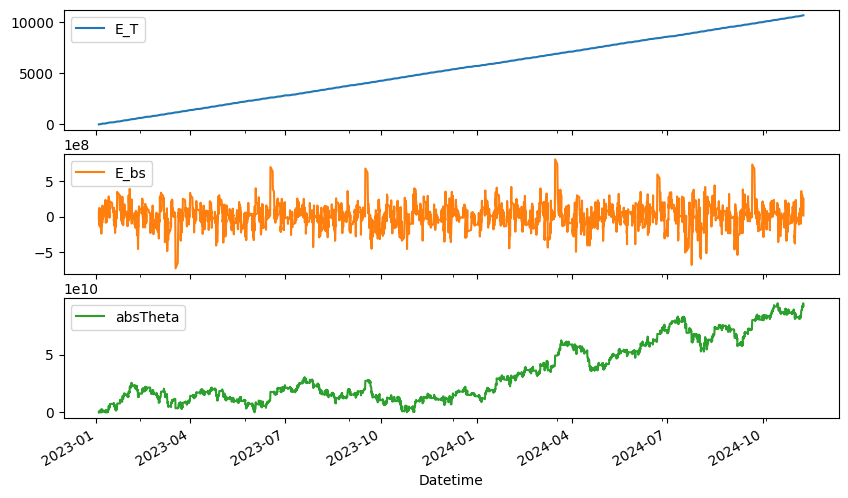

In [41]:
df0[['E_T','E_bs', 'absTheta']].plot(subplots=True, figsize=(10,6))
plt.show()

In [42]:
display(df0.describe()/1000)

,bs,E_T,E_bs,absMul,absTheta
count,1.066200e+01,10.662000,10.662000,1.066200e+01,1.066200e+01
mean,8.680735e+03,5.320516,8686.101641,4.759336e+08,3.402895e+07
std,5.507704e+05,3.077970,123098.237997,6.430059e+08,2.616362e+07
min,-8.153837e+06,0.000000,-732288.300595,0.000000e+00,1.938869e+04
25%,-6.627690e+04,2.655250,-46510.126945,7.421040e+07,1.300723e+07
50%,1.011756e+04,5.320500,10700.195579,2.394007e+08,2.116184e+07
75%,8.506274e+04,7.985750,70079.893789,6.055491e+08,5.678531e+07
max,8.983495e+06,10.651000,814146.615606,7.297943e+09,9.473848e+07


<Axes: >

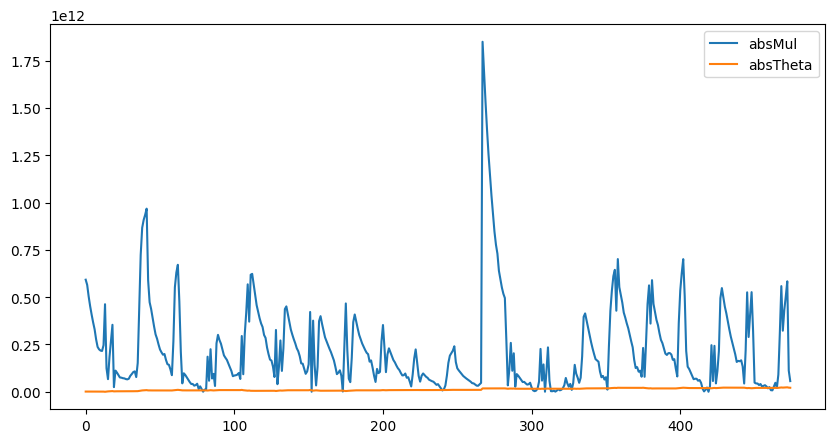

In [43]:
(df0.loc['2023-06',['absMul','absTheta']].reset_index(drop=True).plot(figsize=(10,5)))

In [44]:
def calculate_dollar_imbalance_bars(df, initial_threshold, ewma_alpha=0.95, bar_type = 'Dollar'):
    """
    Calculate dollar imbalance bars with an EWMA-adjusted threshold as per de Prado's method.
    
    Parameters:
    df (pd.DataFrame): A DataFrame with columns ['date', 'open', 'close', 'high', 'low', 'volume'].
    initial_threshold (float): Initial imbalance threshold for triggering a bar.
    ewma_alpha (float): Smoothing factor for EWMA (e.g., 0.95 gives strong weighting to recent observations).
    
    Returns:
    pd.DataFrame: A DataFrame containing the dollar imbalance bars.
    """
    name = df.index.name
    df = df.reset_index()
    imbalance_bars = []  # Store completed imbalance bars
    cumulative_signed_flow = 0  # Tracks cumulative signed imbalance flow
    ewma_threshold = initial_threshold  # Set initial threshold
    Date, Open, High, Low, Volume =df[name].iloc[0], df['Open'].iloc[0], df['High'].iloc[0], df['Low'].iloc[0], df['Volume'].iloc[0]
    i_prev = 0
    T_array = []
    imbalance_array = []
    
    for i in range(1, len(df)):
        price_change = df['Close'].iloc[i] - df['Close'].iloc[i - 1]
        tick_direction = np.sign(price_change)  # Determine tick direction
        if bar_type == 'Dollar':
            signed_flow = tick_direction * df['Volume'].iloc[i] * df['Close'].iloc[i]  # Calculate signed flow
        elif bar_type == 'Volume':
            signed_flow = tick_direction * df['Volume'].iloc[i]
        elif bar_type == 'Tick':
            signed_flow = tick_direction * 1
        else:
            raise ValueError("Wrong bar_type, please select the correct type: Dollar, Volume, Tick")
        
        cumulative_signed_flow += signed_flow  # Accumulate signed flow
        imbalance_array.append(signed_flow)
        
        Volume += df['Volume'].iloc[i]
        High = max(High, df['High'].iloc[i])
        Low = min(Low, df['Low'].iloc[i])

        # Check if we should create a new bar
        if abs(cumulative_signed_flow) >= ewma_threshold:
            # Add the current bar's details to the bars list
            bar = {
                name: Date,
                'Open': Open,
                'Close': df['Close'].iloc[i],
                'High': High,
                'Low': Low,
                'Volume': Volume,
                'Adj Close': df['Adj Close'].iloc[i],
                'Cumulative_signed_flow': cumulative_signed_flow,
                'Threshold': ewma_threshold
            }
            if (i < len(df)-1):
                Open = df['Open'].iloc[i + 1]
                High = df['High'].iloc[i + 1]
                Low = df['Low'].iloc[i + 1]
                Date = df[name].iloc[i + 1]
            i_prev = i
            T_array.append(i - i_prev + 1)
            
            imbalance_bars.append(bar)
            
            # Update cumulative imbalance and EWMA threshold
            E_imbalance = pd.Series(imbalance_array).ewm(alpha=ewma_alpha).mean().values[-1]
            E_T = pd.Series(T_array).ewm(alpha=ewma_alpha).mean().values[-1]
            ewma_threshold = E_T * E_imbalance
            # Reset cumulative signed flow for the next bar
            cumulative_signed_flow = 0
            Volume = 0

    # Return result as a DataFrame
    imbalance_bars_df = pd.DataFrame(imbalance_bars)
    return imbalance_bars_df

# Example usage:
# Assuming df is a DataFrame with the necessary columns.
# initial_threshold = 1e6  # Set the initial threshold value
# ewma_alpha = 0.95  # Smoothing factor for EWMA threshold
# imbalance_bars_df = calculate_dollar_imbalance_bars(df, initial_threshold, ewma_alpha)


In [45]:
df.shape

(10663, 9)

In [46]:
dollar_imb_bars = calculate_dollar_imbalance_bars(df, initial_threshold=10000)
dollar_imb_bars

,Datetime,Open,Close,High,Low,Volume,Adj Close,Cumulative_signed_flow,Threshold
0,2023-01-03 05:00:00+00:00,3864.00,3870.50,3874.25,3864.00,16521,3870.50,-2.952030e+07,1.000000e+04
1,2023-01-03 07:00:00+00:00,3870.25,3881.75,3882.00,3865.75,16333,3881.75,6.340062e+07,-2.952030e+07
2,2023-01-03 08:00:00+00:00,3881.50,3895.25,3897.00,3877.50,38641,3895.25,1.505164e+08,5.897582e+07
3,2023-01-03 09:00:00+00:00,3895.25,3884.00,3906.75,3870.25,207805,3884.00,3.755918e+08,1.459502e+08
4,2023-01-03 14:00:00+00:00,3884.25,3854.00,3901.50,3853.25,255200,3854.00,-9.835408e+08,2.955654e+08
...,...,...,...,...,...,...,...,...,...
3001,2024-11-07 23:00:00+00:00,6007.75,6015.00,6015.50,5990.25,278252,6015.00,6.818502e+08,3.360001e+08
3002,2024-11-08 15:00:00+00:00,6014.50,6021.25,6023.00,6008.50,156969,6021.25,9.451496e+08,7.314873e+08
3003,2024-11-08 16:00:00+00:00,6021.00,6024.75,6027.00,6016.75,180166,6024.75,1.085273e+09,9.344665e+08
3004,2024-11-08 18:00:00+00:00,6024.75,6027.25,6040.50,6020.00,388639,6027.25,-1.413763e+09,5.387829e+08


In [47]:
volume_imb_bars = calculate_dollar_imbalance_bars(df, initial_threshold=10000, bar_type='Volume')
volume_imb_bars

,Datetime,Open,Close,High,Low,Volume,Adj Close,Cumulative_signed_flow,Threshold
0,2023-01-03 05:00:00+00:00,3864.00,3895.25,3897.00,3864.00,71495,3895.25,47347.0,10000.000000
1,2023-01-03 09:00:00+00:00,3895.25,3884.00,3906.75,3870.25,207805,3884.00,96545.0,37471.337292
2,2023-01-03 14:00:00+00:00,3884.25,3854.00,3901.50,3853.25,255200,3854.00,-255200.0,76099.888768
3,2023-01-03 15:00:00+00:00,3854.25,3857.25,3862.50,3837.25,219527,3857.25,219527.0,-238635.005562
4,2023-01-03 16:00:00+00:00,3857.25,3827.25,3860.00,3823.00,197673,3827.25,-197673.0,196618.899722
...,...,...,...,...,...,...,...,...,...
2979,2024-11-07 23:00:00+00:00,6007.75,6015.00,6015.50,5990.25,278252,6015.00,113283.0,55931.797551
2980,2024-11-08 15:00:00+00:00,6014.50,6021.25,6023.00,6008.50,156969,6021.25,156969.0,121607.407652
2981,2024-11-08 16:00:00+00:00,6021.00,6024.75,6027.00,6016.75,180166,6024.75,180166.0,155200.920383
2982,2024-11-08 18:00:00+00:00,6024.75,6027.25,6040.50,6020.00,388639,6027.25,-234569.0,89429.934801


In [48]:
tick_imb_bars = calculate_dollar_imbalance_bars(df, initial_threshold=4, bar_type='Tick')
tick_imb_bars

,Datetime,Open,Close,High,Low,Volume,Adj Close,Cumulative_signed_flow,Threshold
0,2023-01-03 05:00:00+00:00,3864.00,3853.00,3906.75,3814.50,1657275,3853.00,4.0,4.000000
1,2023-01-04 05:00:00+00:00,3853.00,3852.00,3854.00,3849.00,6162,3852.00,-1.0,0.995238
2,2023-01-04 06:00:00+00:00,3852.00,3853.25,3854.25,3847.25,5698,3853.25,1.0,-0.900238
3,2023-01-04 07:00:00+00:00,3853.25,3857.25,3858.00,3852.00,13676,3857.25,1.0,0.904988
4,2023-01-04 08:00:00+00:00,3857.25,3861.00,3866.25,3856.50,35070,3861.00,1.0,0.995249
...,...,...,...,...,...,...,...,...,...
10508,2024-11-08 17:00:00+00:00,6023.00,6024.75,6027.00,6017.75,89179,6024.75,1.0,0.999762
10509,2024-11-08 18:00:00+00:00,6024.75,6034.00,6036.00,6023.25,77035,6034.00,1.0,0.999988
10510,2024-11-08 19:00:00+00:00,6034.00,6033.00,6040.50,6030.75,82903,6033.00,-1.0,0.999999
10511,2024-11-08 20:00:00+00:00,6033.00,6027.25,6033.75,6020.00,228701,6027.25,-1.0,-0.900000


In [49]:
dollar_returns = returns(dollar_bars['Close'])
dollar_imb_returns = returns(dollar_imb_bars['Close'])
bar_types = ['dollar','dollar_imbalance']
pd.DataFrame([dollar_returns.autocorr(), dollar_imb_returns.autocorr()], columns=['returns_corr'], index=['dollar', 'dollar_imbalance'])

,returns_corr
dollar,0.021499
dollar_imbalance,0.030481


In [50]:
volume_returns = returns(volume_bars['Close'])
volume_imb_returns = returns(volume_imb_bars['Close'])
bar_types = ['volume','volume_imbalance']
pd.DataFrame([volume_returns.autocorr(), volume_imb_returns.autocorr()], columns=['returns_corr'], index=['volume', 'volume_imbalance'])

,returns_corr
volume,0.018689
volume_imbalance,0.031861


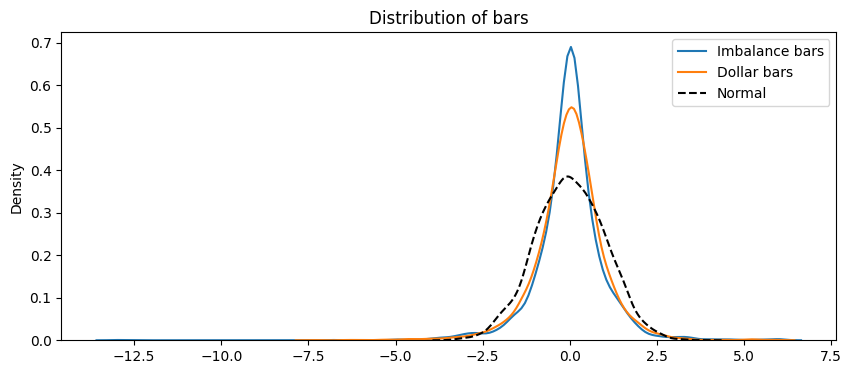

In [51]:
plt.figure(figsize=(10,4))
sns.kdeplot((dollar_imb_returns - dollar_imb_returns.mean()) / dollar_imb_returns.std(), label="Imbalance bars")
sns.kdeplot((dollar_returns - dollar_returns.mean()) / dollar_returns.std(), label="Dollar bars")
sns.kdeplot(np.random.normal(size=len(dollar_returns)), label="Normal", color='black', linestyle="--")
plt.title('Distribution of bars')
plt.legend()
plt.show()

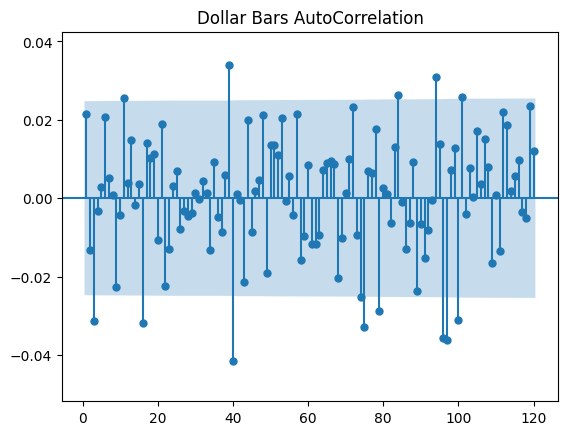

In [52]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dollar_returns,lags=120,alpha=0.05, adjusted=True, fft=True,zero=False, auto_ylims=True)
plt.title('Dollar Bars AutoCorrelation')
plt.show()

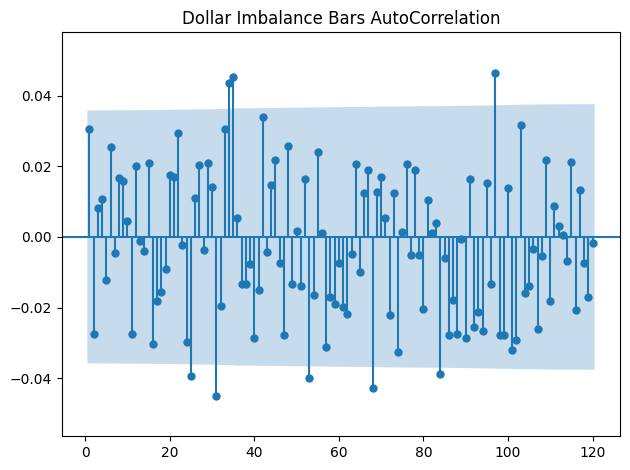

In [53]:
plot_acf(dollar_imb_returns, lags=120,alpha=0.05, adjusted=True, fft=True,zero=False, auto_ylims=True)
plt.title('Dollar Imbalance Bars AutoCorrelation')
plt.tight_layout()
plt.show()

In [54]:
def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(10,4))
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
                                 alpha=0.05, adjusted=True, fft=True,
                                 zero=False, auto_ylims=True,
                                 title=f'{typ} AutoCorr')
    plt.tight_layout()   
    
def plot_dist(bar_types,bar_rets):
    f,axes=plt.subplots(len(bar_types),figsize=(10,4))
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        g = sns.histplot(bar, ax=axes[i], kde=False, label=typ)
        g.set(yscale='log')
        axes[i].legend()
    plt.tight_layout()   

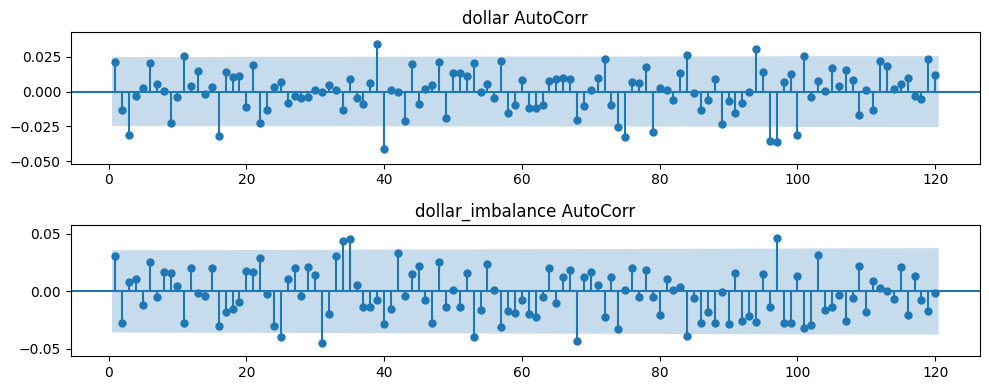

In [55]:
bar_types = ['dollar', 'dollar_imbalance']
bar_returns = [dollar_returns, dollar_imb_returns]
plot_autocorr(bar_types,bar_returns)

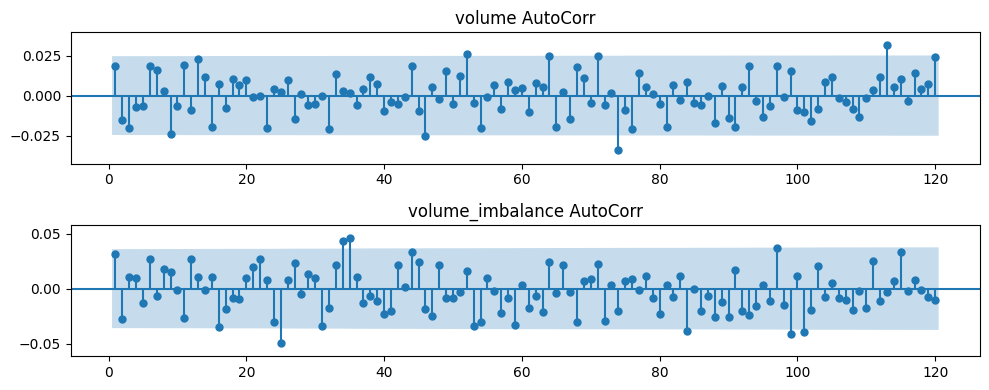

In [56]:
bar_types = ['volume', 'volume_imbalance']
bar_returns = [volume_returns, volume_imb_returns]
plot_autocorr(bar_types,bar_returns)

### Bollinger Bands

In [ ]:
def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    """
    Function to calculate Bollinger Bands.
    :param df: DataFrame containing stock price data (must have 'Close' column)
    :param window: The rolling window for calculating the moving average and standard deviation
    :param num_std_dev: Number of standard deviations to use for the bands
    :return: DataFrame with Bollinger Bands (Upper, Middle, Lower)
    """
    # Calculate the rolling mean (middle band) and rolling standard deviation
    df['SMA'] = df['Close'].rolling(window=window).mean()
    df['STD'] = df['Close'].rolling(window=window).std()

    # Calculate the upper and lower Bollinger Bands
    df['Upper Band'] = df['SMA'] + (df['STD'] * num_std_dev)
    df['Lower Band'] = df['SMA'] - (df['STD'] * num_std_dev)

    return df




In [ ]:
def plot_bollinger_bands(df):
    """
    Function to plot the Bollinger Bands along with the closing price.
    :param df: DataFrame with 'Close', 'Upper Band', and 'Lower Band'
    """
    plt.figure(figsize=(10,6))
    plt.plot(df['Close'], label='Close Price', color='blue')
    plt.plot(df['Upper Band'], label='Upper Bollinger Band', color='red', linestyle='--')
    plt.plot(df['Lower Band'], label='Lower Bollinger Band', color='green', linestyle='--')
    plt.fill_between(df.index, df['Lower Band'], df['Upper Band'], color='gray', alpha=0.3)
    plt.title('Bollinger Bands')
    plt.legend()
    plt.show()

[*********************100%***********************]  1 of 1 completed


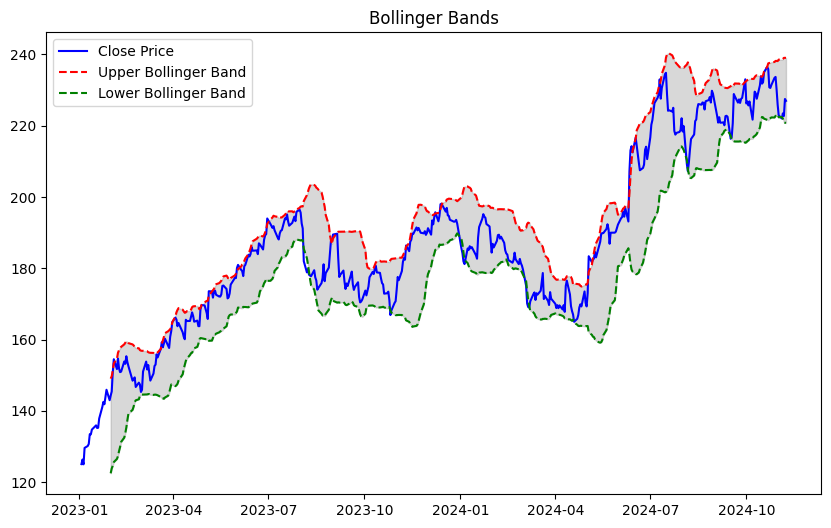

Price                           Close       SMA  Upper Band  Lower Band
Ticker                           AAPL                                  
Date                                                                   
2024-11-04 00:00:00+00:00  222.009995  230.4530  238.470396  222.435604
2024-11-05 00:00:00+00:00  223.449997  230.3370  238.699397  221.974602
2024-11-06 00:00:00+00:00  222.720001  229.9960  239.024887  220.967112
2024-11-07 00:00:00+00:00  227.479996  229.9180  239.008405  220.827595
2024-11-08 00:00:00+00:00  226.960007  229.8885  239.015019  220.761981


In [64]:
# Example: Fetch stock data for a specific ticker
ticker = 'AAPL'  # Apple stock as an example
start_date = '2023-01-01'

# Fetch historical stock data
df = yf.download(ticker, start=start_date)

# Calculate Bollinger Bands
df_with_bands = calculate_bollinger_bands(df)

# Plot the Bollinger Bands
plot_bollinger_bands(df_with_bands)

# Show the first few rows of the DataFrame with the calculated bands
print(df_with_bands[['Close', 'SMA', 'Upper Band', 'Lower Band']].tail())

In [ ]:
yf.download("FEZ", start='2022-11-11', end='2024-10-10', interval="1h") 

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FEZ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1h 2022-11-11 -> 2024-10-10) (Yahoo error = "1h data not available for startTime=1668142800 and endTime=1728532800. The requested range must be within the last 730 days.")')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,FEZ,FEZ,FEZ,FEZ,FEZ,FEZ
Date,,,,,,


In [ ]:
def test_t_abs(absTheta,t,E_bs):
    """
    Bool function to test inequality
    *row is assumed to come from df.itertuples()
    -absTheta: float(), row.absTheta
    -t: pd.Timestamp()
    -E_bs: float(), row.E_bs
    """
    return (absTheta >= t*E_bs)

def agg_imbalance_bars(df):
    """
    Implements the accumulation logic
    """
    start = df.index[0]  
    bars = []
    for row in df.itertuples():
        t_abs = row.absTheta # absolute of cumulative theta
        rowIdx = row.Index
        E_bs = row.E_bs      # expected imbalance dollar values
        t = df.loc[start:rowIdx].shape[0]
        print(t_abs, t, E_bs)
        if t<1: t=1 # if t lt 1 set equal to 1
        if test_t_abs(t_abs,t,E_bs):
            bars.append((start,rowIdx,t,t_abs,E_bs))
            start = rowIdx
    return bars

In [ ]:
bars = agg_imbalance_bars(df0)
test_imb_bars = (pd.DataFrame(bars,columns=['start','stop','Ts', 'abs_theta', 'E_bs']).drop_duplicates())
test_imb_bars

68326993.5 1 68326993.5
144987829.5 2 72675085.23913044
281649911.5 3 95884474.49244332
154448759.5 4 32637228.786300246
31555027.0 2 -4102954.3197559877
106121733.5 2 12016247.178487644
198192500.25 2 26641320.501818277
416136024.0 2 58431573.38746873
637101407.75 2 -112170094.18287073
563478447.25 2 76087625.69815011
328002932.75 2 -54805436.29593274
198021442.25 2 19889251.52897755
764743019.75 2 87166452.62227598
1368682080.25 2 148317830.66764215
327158831.25 2 12281342.935785001
121140586.75 2 -11926796.515170006
44930877.25 2 -18864193.159054987
525701.75 2 -21554426.651400313
53927086.75 2 -13829254.25532669
85034983.0 2 -9287503.097802354
104779415.0 2 -6404409.037859319
87062045.5 2 -7510208.450838044
57860206.25 2 -9600358.77125527
91756863.5 2 -5462982.729309186
128372494.5 2 -1507143.8394270164
224807339.5 2 7603174.68006117
137897559.0 2 -1103863.3465516344
195895595.25 2 4293465.83532115
254232335.25 2 9189712.447128631
321317054.25 2 14397087.610719541
207680180.25 2 29

,start,stop,Ts,abs_theta,E_bs
0,2022-11-11 06:00:00+00:00,2022-11-11 06:00:00+00:00,1,6.832699e+07,6.832699e+07
1,2022-11-11 06:00:00+00:00,2022-11-11 09:00:00+00:00,4,1.544488e+08,3.263723e+07
2,2022-11-11 09:00:00+00:00,2022-11-11 10:00:00+00:00,2,3.155503e+07,-4.102954e+06
3,2022-11-11 10:00:00+00:00,2022-11-11 11:00:00+00:00,2,1.061217e+08,1.201625e+07
4,2022-11-11 11:00:00+00:00,2022-11-11 12:00:00+00:00,2,1.981925e+08,2.664132e+07
...,...,...,...,...,...
11392,2024-11-08 16:00:00+00:00,2024-11-08 17:00:00+00:00,2,1.070975e+11,2.309992e+08
11393,2024-11-08 17:00:00+00:00,2024-11-08 18:00:00+00:00,2,1.075623e+11,2.504850e+08
11394,2024-11-08 18:00:00+00:00,2024-11-08 19:00:00+00:00,2,1.070622e+11,1.879318e+08
11395,2024-11-08 19:00:00+00:00,2024-11-08 20:00:00+00:00,2,1.056837e+11,5.740097e+07


In [ ]:
df0.shape

(11414, 5)

In [ ]:
len(bars)

11397

In [ ]:
test_imb_bars.Ts.describe().round()

count    11397.0
mean         2.0
std          0.0
min          1.0
25%          2.0
50%          2.0
75%          2.0
max         17.0
Name: Ts, dtype: float64

<Axes: xlabel='stop'>

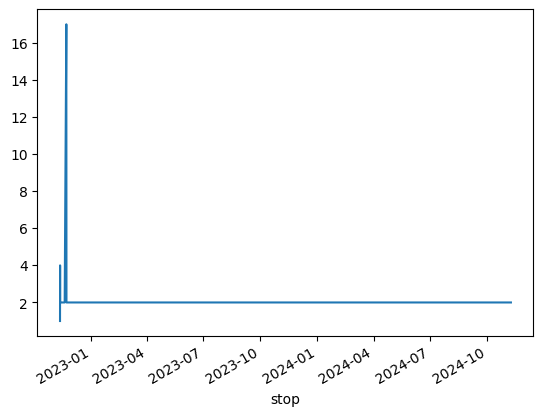

In [ ]:
test_imb_bars.set_index('stop')['Ts'].plot()

In [ ]:
dvImbBars = df.price.loc[test_imb_bars.stop].drop_duplicates()
dvImbBars

Datetime
2022-11-11 06:00:00+00:00    3988.50
2022-11-11 09:00:00+00:00    3984.00
2022-11-11 10:00:00+00:00    3976.50
2022-11-11 11:00:00+00:00    3980.50
2022-11-11 12:00:00+00:00    3980.75
                              ...   
2024-11-08 17:00:00+00:00    6024.75
2024-11-08 18:00:00+00:00    6034.00
2024-11-08 19:00:00+00:00    6033.00
2024-11-08 20:00:00+00:00    6027.25
2024-11-08 21:00:00+00:00    6023.50
Name: price, Length: 5535, dtype: float64

In [ ]:
dvBar = dv_bar_df.price
dvBar

NameError: name 'dv_bar_df' is not defined

In [ ]:
ib_data['b'] = 1
ib_data['Close_diff'] = ib_data['Close'].diff()
ib_data['b'] = np.where(ib_data['Close_diff'] != 0, abs(ib_data['Close_diff'])/ib_data['Close_diff'], np.nan)
ib_data['b'] = ib_data['b'].ffill()

In [ ]:
wdow = len(ib_data)//1000000
E_imbalance_init = 100
E_T_init = 3
E_imbalance = E_imbalance_init
E_T = E_T_init
cum_theta = 0
imbalance_array = pd.DataFrame(columns=['Imbalance'])
T_array = pd.DataFrame(columns=['T'])
i_prev = 0

for i in range(1, len(ib_data)):
    imbalance = ib_data.iloc[i]['b'] * ib_data.iloc[i]['Volume'] * ib_data.iloc[i]['Close']
    cum_theta += imbalance
    imbalance_array.loc[len(imbalance_array)] = [imbalance]
    if abs(cum_theta) >= E_T * abs(E_imbalance):
        print(cum_theta, E_imbalance, E_T)
        cum_theta = 0
        T_array.loc[len(T_array)] = [i - i_prev]
        i_prev = i
        E_T = T_array['T'].ewm(wdow).mean().values[-1]
        E_imbalance = imbalance_array['Imbalance'].ewm(wdow).mean().values[-1]

68326993.5 100 3
76660836.0 68326993.5 1.0
136662082.0 76660836.0 1.0
-250094884.5 136662082.0 1.0
384580997.0 -122893732.5 2.0
-1053237431.75 217943523.75 3.0
1200579855.0 -1053237431.75 1.0
1298407650.5 1200579855.0 1.0
19597793748.75 837392000.0 23.0


In [ ]:
T_array

,T
0,1
1,1
2,1
3,2
4,3
5,1
6,1
7,23
8,1027


<Axes: xlabel='Datetime'>

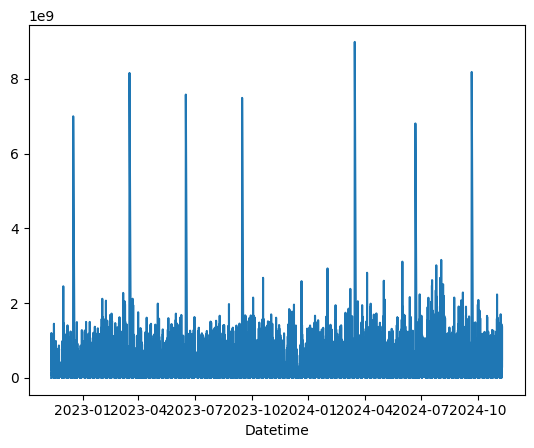

In [ ]:
sns.lineplot(ib_data['Volume']*ib_data['Close'])

In [ ]:
imbalance_array

,Imbalance
0,6.832699e+07
1,7.666084e+07
2,1.366621e+08
3,-1.272012e+08
4,-1.228937e+08
...,...
11409,5.372812e+08
11410,4.648292e+08
11411,-5.001538e+08
11412,-1.378438e+09
